In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from SIR_EAKF_model import *

# Synthetic SIR model to generate data
def run_sir_model(N, beta, gamma, S0, I0, R0, days):
    """
    Generate synthetic SIR data using given parameters.

    Parameters:
        N: int
            Total population.
        beta: float
            Transmission rate.
        gamma: float
            Recovery rate.
        S0, I0, R0: int
            Initial values for S, I, and R.
        days: int
            Number of days to simulate.

    Returns:
        sir_data: pd.DataFrame
            A DataFrame containing daily S, I, and R values.
    """
    S, I, R = S0, I0, R0
    sir_data = {"day": [], "S": [], "I": [], "R": []}

    for day in range(days):
        sir_data["day"].append(day)
        sir_data["S"].append(S)
        sir_data["I"].append(I)
        sir_data["R"].append(R)

        new_infected = beta * S * I / N
        new_recovered = gamma * I

        S = max(S - new_infected, 0)
        I = max(I + new_infected - new_recovered, 0)
        R = min(R + new_recovered, N)

    return pd.DataFrame(sir_data)

# Accumulate daily data into weekly data
def accumulate_weekly_data(sir_data):
    """
    Accumulate daily SIR data into weekly infection counts.

    Parameters:
        sir_data: pd.DataFrame
            Daily SIR data.

    Returns:
        weekly_I: np.ndarray
            Weekly cumulative infections.
    """
    daily_I_diff = -np.diff(sir_data["S"], prepend=sir_data["S"].iloc[0])
    weekly_I = np.add.reduceat(daily_I_diff, np.arange(0, len(daily_I_diff), 7))
    return weekly_I


In [247]:
# Generate synthetic data
N = 1e6
beta = 0.7
gamma = 0.25
S0 = 0.5*N
I0 = 100
R0 = N - S0 - I0
days = 7*20  
reporting_factor = 0.003

sir_data = run_sir_model(N, beta, gamma, S0, I0, R0, days)
weekly_I = accumulate_weekly_data(sir_data).astype(int)
obs_I = np.random.binomial(weekly_I, reporting_factor)

In [248]:
# Define the EAKF procedure
weeks_to_predict = 4  # 4-week prediction horizon
num_ensembles = 100
S_min, S_max = 0.3 * N, 0.7 * N
I_min, I_max = 1, 200
beta_min, beta_max = 0.5, 1
gamma_min, gamma_max = 0.2, 0.5
rf_min, rf_max = 0.003, 0.003

# Use EAKF to predict from a certain starting point
start_point = 7  # Week 6 as the start for prediction
obs_data = obs_I[:start_point]

inflation_factor = 1.05

obs_I_ens = sir_eakf(num_ensembles, N, S_min, S_max, I_min, I_max, 
                    beta_min, beta_max, gamma_min, gamma_max, 
                    weeks_to_predict, obs_data, 
                    None, reporting_factor, inflation_factor)

Week 0: obs_var=0.0100
Week 1: obs_var=0.0400
Week 2: obs_var=0.0400
Week 3: obs_var=1.0000
Week 4: obs_var=1.6900
Week 5: obs_var=8.4100
Week 6: obs_var=6.2500


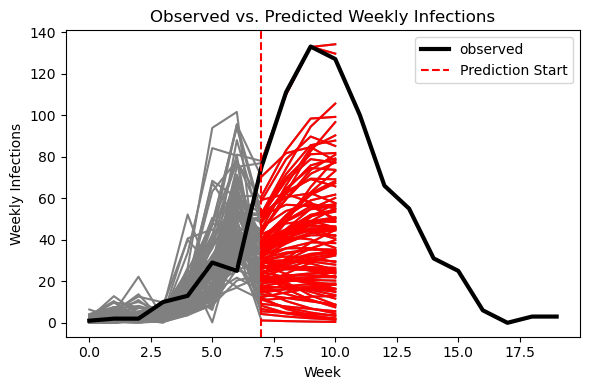

In [249]:
plt.figure(figsize=(6, 4))
plt.plot(range(start_point+weeks_to_predict),obs_I_ens,color='gray')
plt.plot(range(start_point,start_point+weeks_to_predict),obs_I_ens[range(start_point,start_point+weeks_to_predict),:],color='red')
plt.plot(obs_I,color='black',linewidth=3, label='observed')
plt.axvline(x=start_point, color="red", linestyle="--", label="Prediction Start")
plt.xlabel("Week")
plt.ylabel("Weekly Infections")
plt.title("Observed vs. Predicted Weekly Infections")
plt.legend()
plt.tight_layout()
plt.show()

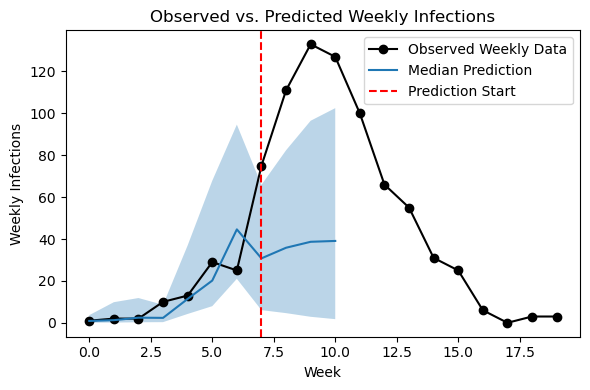

In [250]:
# Compute quantiles for the predictions
quantiles = [0.025, 0.5, 0.975]
quantile_df = compute_quantiles_from_ensemble(obs_I_ens, quantiles)
quantile_df

# Plot observed vs. predicted
plt.figure(figsize=(6, 4))
plt.plot(range(len(weekly_I)), obs_I, label="Observed Weekly Data", marker="o",color='black')
plt.plot(quantile_df["week"], quantile_df["50.0%"], label=f"Median Prediction")
plt.fill_between(quantile_df["week"], quantile_df["2.5%"], quantile_df["97.5%"], alpha=0.3)
plt.axvline(x=start_point, color="red", linestyle="--", label="Prediction Start")
plt.xlabel("Week")
plt.ylabel("Weekly Infections")
plt.title("Observed vs. Predicted Weekly Infections")
plt.legend()
plt.tight_layout()
plt.show()